In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mode_connectivity.models.mlp import MLP
from mode_connectivity.training import test
from mode_connectivity.utils import utils, data
from mode_connectivity.lmc import model_interpolation

In [4]:
geodesic_weights = torch.load("../model_files/opt_weights_mlpab_fullmnist_maxiter1k_lr02.pt", map_location="cpu")

euclidean distance of geodesic:  40.731833696365356
euclidean distance of straight line:  40.706646


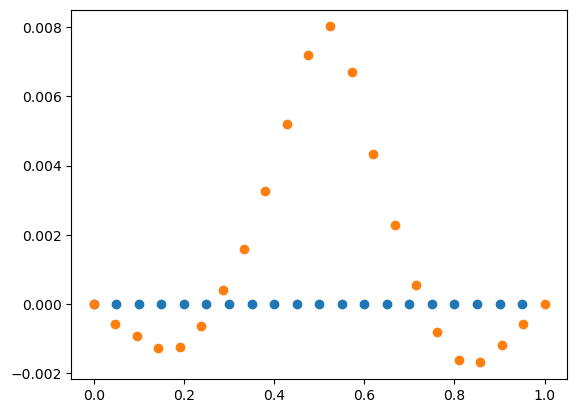

In [5]:
v_start = utils.state_dict_to_numpy_array(geodesic_weights[0])
v_end = utils.state_dict_to_numpy_array(geodesic_weights[-1])
straight_line_distance = np.linalg.norm(v_start - v_end)

# Calculates the shortest distance from p3 to the line p1----p2
def distance_to_line(p1, p2, p3):
    line = p2- p1
    point = p3 - p1
    projected_point = np.dot(line, point)
    pp = projected_point/np.linalg.norm(line)
    pn = np.linalg.norm(point)
    return np.sqrt(pn**2 - pp**2)

distances_to_line = [(distance_to_line(v_start, v_end, utils.state_dict_to_numpy_array(weights))) for weights in geodesic_weights]
furthest_point = geodesic_weights[np.array(distances_to_line).argmax()]

# We generate the plane to project into by taking the third vector as the point on the geodesic farthest away
# from the straight line (to make the curve as curvy as possible)
furthest_point_plane = utils.generate_orthogonal_basis(v_start, v_end, utils.state_dict_to_numpy_array(furthest_point))

v1 = utils.state_dict_to_numpy_array(geodesic_weights[0])
distances = []
furthest_projected_points = [utils.projection(v1, furthest_point_plane)]
for weights in geodesic_weights[1:]:
    v2 = utils.state_dict_to_numpy_array(weights)
    euclidean_distance = np.linalg.norm(v1 - v2)
    distances.append(euclidean_distance)
    furthest_projected_points.append(utils.projection(v2, furthest_point_plane))
    v1 = v2


def linear_interp(lam, p1, p2):
    p3 = []
    for x1, x2 in zip(p1, p2):
        p3.append((1 - lam) * x1 + lam * x2)
    return tuple(p3)

print("euclidean distance of geodesic: ", sum(distances))
print("euclidean distance of straight line: ", straight_line_distance)

straight_line_points = [
    linear_interp(lam, furthest_projected_points[0], furthest_projected_points[-1]) for lam in np.arange(0, 1, 0.05)]
plt.scatter(np.array(straight_line_points)[:,0],np.array(straight_line_points)[:,1],)
plt.scatter(np.array(furthest_projected_points)[:, 0], np.array(furthest_projected_points)[:, 1])


In [6]:
# Calculate test loss and accuracy along geodesic
train_loader, test_loader = data.get_data_loaders("mnist", train_kwargs={"batch_size":512}, test_kwargs={"batch_size":512})

model = MLP()
geodesic_df = {"train_acc":[], "train_loss":[], "test_acc":[], "test_loss":[]}
for weights in geodesic_weights:
    model.load_state_dict(weights)
    train_loss, train_acc = test(model, "cpu", train_loader, verbose=0)
    test_loss, test_acc = test(model, "cpu", test_loader, verbose=0)
    geodesic_df["test_acc"].append(test_acc)
    geodesic_df["test_loss"].append(test_loss)
    geodesic_df["train_acc"].append(train_acc)
    geodesic_df["train_loss"].append(train_loss)


In [7]:
# Calculate accuracies along linear interpolated path
model_a = MLP()
model_a.load_state_dict(geodesic_weights[0])
model_b = MLP()
model_b.load_state_dict(geodesic_weights[-1])

train_acc_naive, test_acc_naive = model_interpolation(
    model_a,
    model_b, 
    train_loader,
    test_loader,
    device="cpu",
    n_points=22, verbose=1)

<AxesSubplot:>

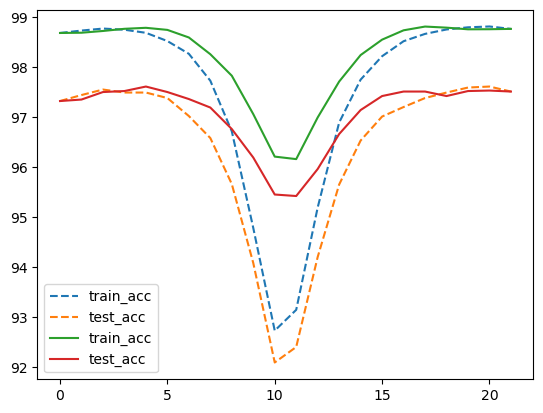

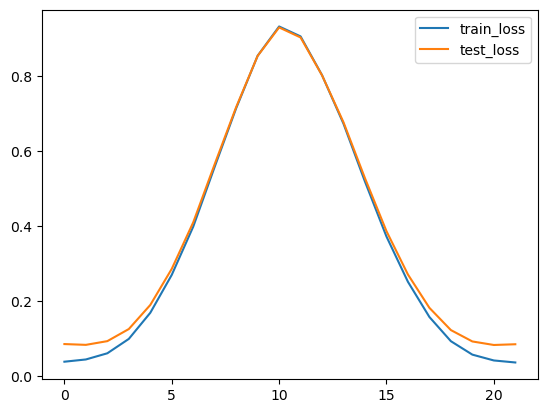

In [8]:
# Generate plots
naive_df = pd.DataFrame({'train_acc':train_acc_naive, "test_acc":test_acc_naive})

geodesic_df = pd.DataFrame(geodesic_df)
ax = naive_df[["train_acc", "test_acc"]].plot(linestyle='--')
geodesic_df[["train_acc", "test_acc"]].plot(ax=ax)
geodesic_df[["train_loss", "test_loss"]].plot()